## Problematic GRB
This is the GRB 050128, with 2ms time gap between points.
Works as expected:-

| No of Data Points    | Time Taken |
| -------- | -------   |
|  20      |  2.2 min   |
| 120      |  54 min   |

## Loading Dependencies

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


## Loading Data:
This code is mainly to pick up the text file of the specified GRB and convert it into a numpy arrays

In [2]:
def truncate_data(times: np.ndarray, counts: np.ndarray, start: float, stop: float, yerr: np.ndarray = None) -> tuple:
    indices = np.where(np.logical_and(times > start, times < stop))[0]
    if yerr is None:
        return times[indices], counts[indices]
    else:
        return times[indices], counts[indices], yerr[indices]

def get_grb_data_from_segment(
        grb_id: str, grb_binning: str, start_time: float, end_time: float, grb_detector: str = None,
        grb_energy_band: str = "all", grb_label: str = None, bin_size: str = None, **kwargs) -> tuple:
    times, y, yerr = get_all_grb_data(grb_binning=grb_binning, grb_id=grb_id, grb_detector=grb_detector,
                                      grb_label=grb_label, grb_energy_band=grb_energy_band, bin_size=bin_size)
    return truncate_data(times=times, counts=y, start=start_time, stop=end_time, yerr=yerr)


def get_all_grb_data(
        grb_id: str, grb_binning: str, grb_detector: str = None, grb_energy_band: str = "all", grb_label: str = None,
        bin_size: str = None, **kwargs) -> tuple:
    if grb_detector in ["swift", "konus"]:
        data_file = f"data/GRBs/GRB{grb_id}/{grb_binning}_lc_ascii_{grb_detector}.txt"
        data = np.loadtxt(data_file)
        times = data[:, 0]
        if grb_detector == "swift":
            if grb_energy_band == "15-25":
                y = data[:, 1]
                yerr = data[:, 2]
            elif grb_energy_band == "25-50":
                y = data[:, 3]
                yerr = data[:, 4]
            elif grb_energy_band == "50-100":
                y = data[:, 5]
                yerr = data[:, 6]
            elif grb_energy_band == "100-350":
                y = data[:, 7]
                yerr = data[:, 8]
            elif grb_energy_band in ["all", "15-350"]:
                y = data[:, 9]
                yerr = data[:, 10]
            else:
                raise ValueError(f"Energy band {grb_energy_band} not understood")
            return times, y, yerr
        elif grb_detector == "konus":
            y = data[:, 1]
            return times, y, np.sqrt(y)
    elif grb_detector == "batse":
        data_file = f"data/GRBs/GRB{grb_id}/GRB{grb_id}_{grb_energy_band}"
        data = np.loadtxt(data_file)
        times = data[:, 0]
        y = data[:, 1]
        yerr = np.sqrt(y)
        return times, y, yerr
    elif grb_detector.lower() == "asim":
        data_file = f"data/GRBs/GRB{grb_id}/{grb_label}.txt"
        ttes = np.loadtxt(data_file)
        y, bin_edges = np.histogram(ttes, np.arange(ttes[0], ttes[-1], bin_size))
        times = np.array([bin_edges[i] + (bin_edges[i + 1] - bin_edges[i]) / 2 for i in range(len(bin_edges) - 1)])
        yerr = np.sqrt(y)
        return times, y, yerr
    
_GRB_RUN_MODES = dict(select_time=get_grb_data_from_segment,
                      entire_segment=get_all_grb_data)

def get_grb_data(run_mode: str, **kwargs) -> tuple:
    """ Catch all function """
    return _GRB_RUN_MODES[run_mode](**kwargs)

## Labels for our GRB

In [3]:
grb_id = "090709A"
grb_label = ""
grb_binning = "1s"
grb_detector = "swift"
grb_energy_band = "all"

times, y, yerr = get_all_grb_data(
        grb_id = grb_id, grb_binning = grb_binning, grb_detector = grb_detector, 
        grb_energy_band = grb_energy_band, grb_label= grb_label,
        bin_size= None)

In [4]:
print(times.shape, y.shape, yerr.shape)

(782,) (782,) (782,)


#### Plotting the Total Lightcurve
Has a 782 points

<ErrorbarContainer object of 3 artists>

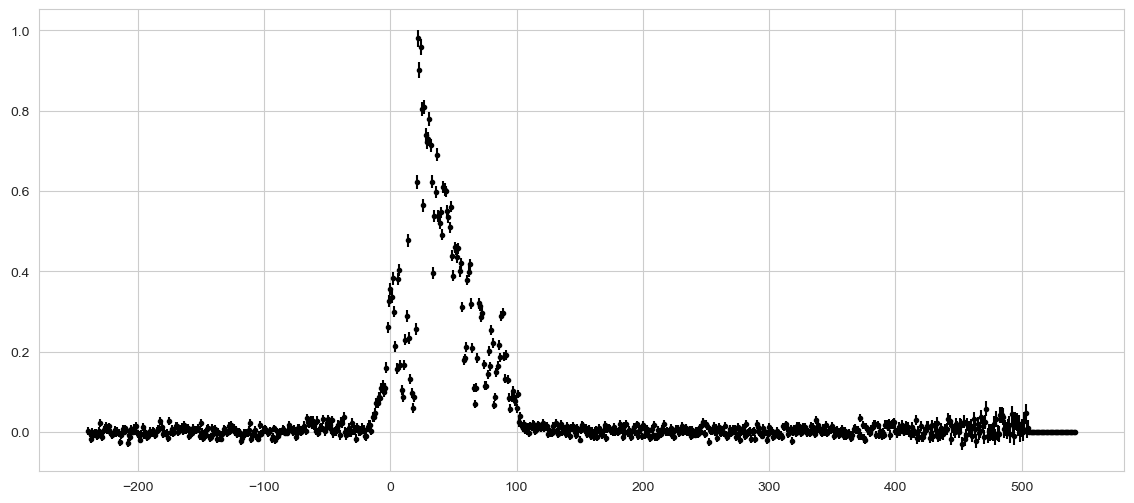

In [5]:
fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.errorbar(times, y, yerr=yerr, fmt=".k", capsize=0, label="data")

## Slicing the GRB
Here We can slice the data by putting the start and end time that we want to use

**Saved as times2, y2, yerr2**

Example from t = -10.0 to t = +110.0
This will give us a lightcurve of 120 points

In [6]:
times2, y2, yerr2 = get_grb_data_from_segment(
        grb_id = grb_id, grb_binning = grb_binning, start_time = -10.0, end_time = +110, grb_detector = grb_detector,
        grb_energy_band = grb_energy_band, grb_label = grb_label, bin_size= None)
print(times2.shape, y2.shape, yerr2.shape)

(120,) (120,) (120,)


<ErrorbarContainer object of 3 artists>

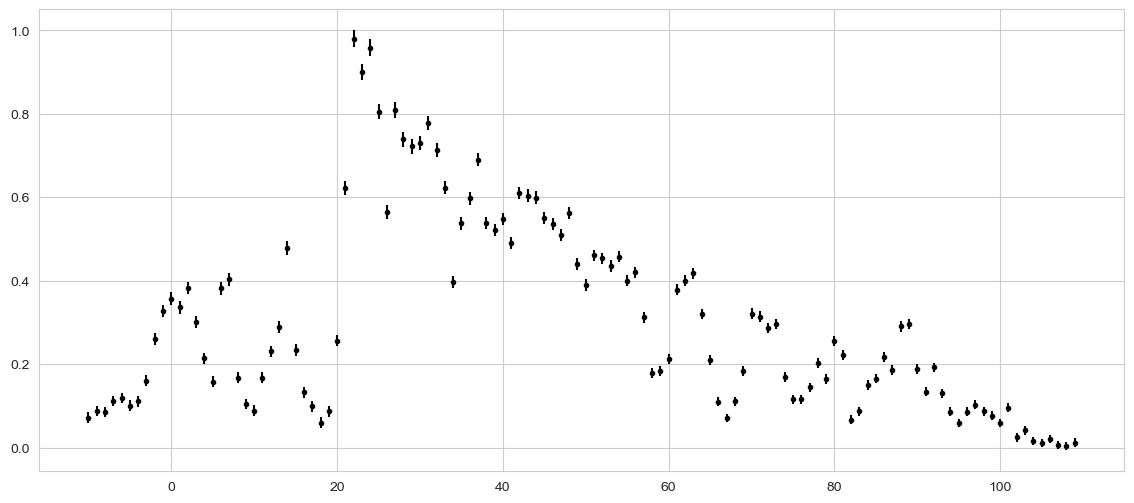

In [7]:
fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.errorbar(times2, y2, yerr=yerr2, fmt=".k", capsize=0, label="data")

## Posterior Sampling

For sliced data (120 points) using **times2, y2, yerr2**.

Stopped the sampling as it took a lot of time.

In [17]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")
import tensorflow_probability.substrates.jax as tfp
from gpmodelling import get_prior, get_likelihood, get_gp_params, get_kernel, get_mean
tfpd = tfp.distributions
tfpb = tfp.bijectors

from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list2 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list2)

['arn', 'crn', 'aqpo', 'cqpo', 'freq', 'A', 't0', 'sig']


In [18]:
params_list = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")

counts2 = y2
total_time = times2[-1] - times2[0]
f = 1/(times2[1]- times2[0])
span = jnp.max(counts2) - jnp.min(counts2)

prior_dict = {
    "A": tfpd.Uniform(low = 0.1 * span, high= 2 * span),
    "t0": tfpd.Uniform(low = times2[0] - 0.1*total_time, high = times2[-1] + 0.1*total_time),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * total_time),

    "arn": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "crn": tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)),
    
    "aqpo": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "cqpo": tfpd.Uniform(low = 1/10/total_time, high = jnp.log(f)),
    "freq": tfpd.Uniform(low = 2 , high = f/4 ),
}

prior_model4 = get_prior(params_list, prior_dict)

likelihood_model4 = get_likelihood(params_list, kernel_type= "QPO_plus_RN", mean_type = "gaussian", Times = times2, counts = counts2)

In [19]:
from jaxns import ExactNestedSampler, TerminationCondition, Prior, Model
from jax import random

NSmodel = Model(prior_model=prior_model4, log_likelihood=likelihood_model4)
NSmodel.sanity_check(random.PRNGKey(10), S=100)

Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=1e4)
Termination_reason, State = Exact_ns(
    random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
)
Results = Exact_ns.to_results(State, Termination_reason)
print("Simulation Complete")

INFO[2023-08-03 00:05:25,163]: Sanity check...
INFO[2023-08-03 00:05:25,588]: Sanity check passed


XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  <__array_function__ internals>(4): diff
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/tinygp/solvers/quasisep/solver.py(141): _check_sorted
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/debugging.py(227): _flat_callback
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/debugging.py(85): debug_callback_impl
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/debugging.py(146): _callback
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/interpreters/mlir.py(1833): _wrapped_callback
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/interpreters/pxla.py(2172): __call__
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/profiler.py(314): wrapper
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/pjit.py(1314): _pjit_call_impl
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/core.py(807): process_primitive
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/core.py(363): bind_with_trace
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/core.py(2577): bind
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/pjit.py(184): _python_pjit_helper
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/pjit.py(235): cache_miss
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/traceback_util.py(166): reraise_with_filtered_traceback
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jaxns/nested_sampler.py(313): __call__
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jaxns/nested_sampler.py(400): __call__
  /var/folders/z9/d9jc5k554dl6jd5l6z3_h5f80000gn/T/ipykernel_61946/1828580543.py(8): <cell line: 8>
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3398): run_code
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3338): run_ast_nodes
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3135): run_cell_async
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2936): _run_cell
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2881): run_cell
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py(528): run_cell
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py(383): do_execute
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py(730): execute_request
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py(499): process_one
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /opt/homebrew/anaconda3/lib/python3.9/asyncio/events.py(80): _run
  /opt/homebrew/anaconda3/lib/python3.9/asyncio/base_events.py(1905): _run_once
  /opt/homebrew/anaconda3/lib/python3.9/asyncio/base_events.py(601): run_forever
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py(199): start
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py(712): start
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py(846): launch_instance
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py(17): <module>
  /opt/homebrew/anaconda3/lib/python3.9/runpy.py(87): _run_code
  /opt/homebrew/anaconda3/lib/python3.9/runpy.py(197): _run_module_as_main
